In [6]:
import pandas as pd
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/zaur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Данные были извлечены с платформы kaggle (https://www.kaggle.com/competitions/product-reviews-sentiment-analysis-light/data?select=products_sentiment_train.tsv). В этом датасете собраны отзывы на различные товары, и необходимо провести классификацию всех отзывов на 2 категории: 1 - положительные, 0 - отрицательные. В файле train.csv отзывы уже имеют метки. Мы разделим датасет на несколько частей: в первой части будут отзывы с уже имеющимися метками, во второй части мы проведем разметку с помощью библиотеки textblob, в третьей части проведем разметку в Label Studio, а в четвертой части создадим правила для разметки.

In [7]:
df = pd.read_csv('products_sentiment_train.tsv', delimiter='\t')
df.head()

,"2 . take around 10,000 640x480 pictures .",1
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


In [8]:
df.columns

Index(['2 . take around 10,000 640x480 pictures .', '1'], dtype='object')

Переименуем колонки

In [9]:
df.rename(columns={'2 . take around 10,000 640x480 pictures .': 'review', '1': 'mark'}, inplace=True)
df.head()

,review,mark
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


Разделим датасет на части

In [10]:
size_1 = int(len(df) * 0.75)  # 75% данных от общего размера
size_2 = int(len(df) * 0.10)  # 10% данных от общего размера
size_3 = int(len(df) * 0.05)  # 5% данныхот общего размера

In [20]:
part_1 = df.iloc[:size_1] # часть данных с отметкой
part_2 = df.iloc[size_1:size_1+size_2] # 10% для разметки c textblob
part_3 = df.iloc[size_1+size_2:size_1+size_2+size_2] # 10% для разметки по правилам
part_4 = df.iloc[size_1+size_2+size_2:] # 5% для разметки в Label Studio

In [21]:
df.shape

(1999, 2)

In [22]:
part_1.shape[0], part_2.shape[0], part_3.shape[0], part_4.shape[0]

(1499, 199, 199, 102)

## Проведём разметку с textblob

In [23]:
part_2.head()

,review,mark
1499,"the possibilities with auto , manual , and the...",1
1500,"of course , if you try to reach symantec custo...",0
1501,i am impressed with how easy this camera is to...,1
1502,"i was looking for a compact , rugged ( i carry...",1
1503,zennx 's replaceable battery was the deciding ...,1


In [16]:
def get_marked(review):
    blob = TextBlob(review)
    marked = blob.sentiment.polarity
    return marked

def get_mark_textblob(marked):
    if marked >= 0:
        return 1
    return 0

In [25]:
part_2['sentiment'] = part_2.review.apply(get_marked)
part_2['mark'] = part_2.sentiment.apply(get_mark_textblob)
part_2.head()

/tmp/ipykernel_92528/2848100912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_2['sentiment'] = part_2.review.apply(get_marked)
/tmp/ipykernel_92528/2848100912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_2['mark'] = part_2.sentiment.apply(get_mark_textblob)


,review,mark,sentiment
1499,"the possibilities with auto , manual , and the...",1,0.058333
1500,"of course , if you try to reach symantec custo...",0,-0.500000
1501,i am impressed with how easy this camera is to...,1,0.716667
1502,"i was looking for a compact , rugged ( i carry...",1,0.433333
1503,zennx 's replaceable battery was the deciding ...,1,0.000000


In [27]:
part_2.drop(columns=['sentiment'], inplace=True)
part_2.head()

/tmp/ipykernel_92528/4267654713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_2.drop(columns=['sentiment'], inplace=True)


,review,mark
1499,"the possibilities with auto , manual , and the...",1
1500,"of course , if you try to reach symantec custo...",0
1501,i am impressed with how easy this camera is to...,1
1502,"i was looking for a compact , rugged ( i carry...",1
1503,zennx 's replaceable battery was the deciding ...,1


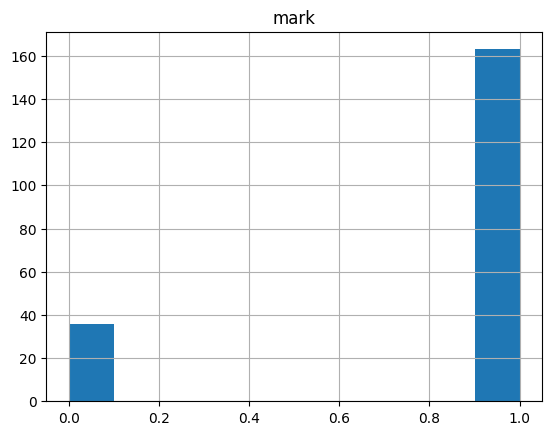

In [29]:
part_2.hist();

## Разметка с помощью заданных правил

В этой части набора данных мы определим классы на основе присутствия положительных слов в отзывах. Если отзыв не содержит таких слов, то ему будет присвоена метка 0, что может означать нейтральный или отрицательный отзыв. 

In [30]:
positive_words = ['good', 'great', 'amazing', 'recommend', 'creative', 'fine', 'comfortable', 'pretty', 
                 'as well', 'fantastically', 'terrific', 'love', 'like', 'easy', 'winner', 'perfect', 'nice',
                 'flawlessly', 'happy', 'fast', 'marvel', 'powerful', 'solve', 'bright', 'surprisingly',
                 'excellent', 'outstanding', 'wonderful', 'superb', 'delightful', 'success', 'impressive', 
                 'brilliant', 'charming', 'genius', 'pleasure', 'vibrant', 'thrilling', 'exceptional', 'joyful',
                 'breathtaking', 'captivating', 'sweet', 'magical', 'gorgeous', 'exquisite', 'remarkable']

In [32]:
part_3.head()

,review,mark
1698,camera quality isn 't bad for the low resoluti...,1
1699,1 ) fragile ( i broke the 1st one within 10 da...,0
1700,the smooth operation variable speed and a set ...,1
1701,i 've had nothing but good luck with t-mobile .,1
1702,"es , the interface took a little getting used ...",0


In [31]:
def get_sentiment_by_rule(review):
    words = nltk.word_tokenize(review.lower())
    num_positive = sum([1 for word in words if word in positive_words])
    if num_positive > 0:
        return 1
    return 0

In [33]:
part_3['mark'] = part_3.review.apply(get_sentiment_by_rule)
part_3.head()

/tmp/ipykernel_92528/3565391521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_3['mark'] = part_3.review.apply(get_sentiment_by_rule)


,review,mark
1698,camera quality isn 't bad for the low resoluti...,0
1699,1 ) fragile ( i broke the 1st one within 10 da...,0
1700,the smooth operation variable speed and a set ...,1
1701,i 've had nothing but good luck with t-mobile .,1
1702,"es , the interface took a little getting used ...",0


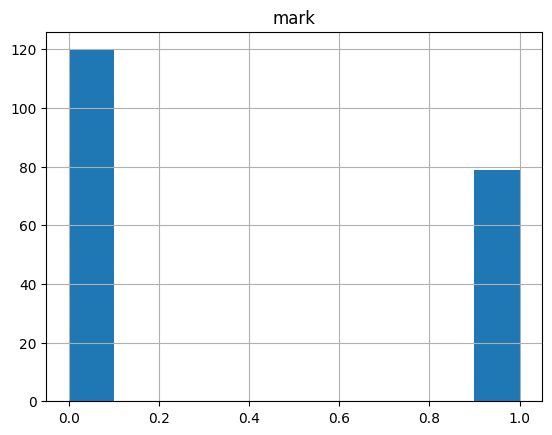

In [34]:
part_3.hist();

## Разметка данных с помощью Label Studio

In [35]:
part_4 = part_4[['review']]
part_4.head()

,review
1897,"after installation , which was very simple ......"
1898,no one has ever come to my house and noticed '...
1899,it is hot enough to be annoying .
1900,the nomad explorer provide most of the functio...
1901,this program enables the user to batch convert...


In [38]:
part_4.to_csv('part_4.csv', index=False)

![photo1](photo1.png)

![photo1](photo2.png)

![photo1](photo3.png)

In [78]:
part_4_new = pd.read_csv('new_part4.csv')
part_4 = part_4_new[['review', 'sentiment']]
part_4.head()

,review,sentiment
0,"after installation , which was very simple ......",1
1,no one has ever come to my house and noticed '...,1
2,it is hot enough to be annoying .,0
3,the nomad explorer provide most of the functio...,1
4,this program enables the user to batch convert...,1


In [79]:
part_4.rename(columns={'sentiment': 'mark'}, inplace=True)

/tmp/ipykernel_92528/2821916658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_4.rename(columns={'sentiment': 'mark'}, inplace=True)


In [80]:
part_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  102 non-null    object
 1   mark    102 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


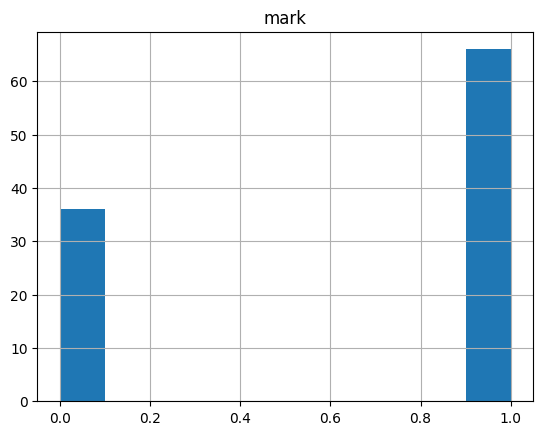

In [81]:
part_4.hist();

Объединим все части датасета

In [82]:
data = pd.concat([part_1, part_2, part_3, part_4])

In [83]:
data.shape

(1999, 2)

In [84]:
data.reset_index(drop=True, inplace=True)

In [85]:
data.head()

,review,mark
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


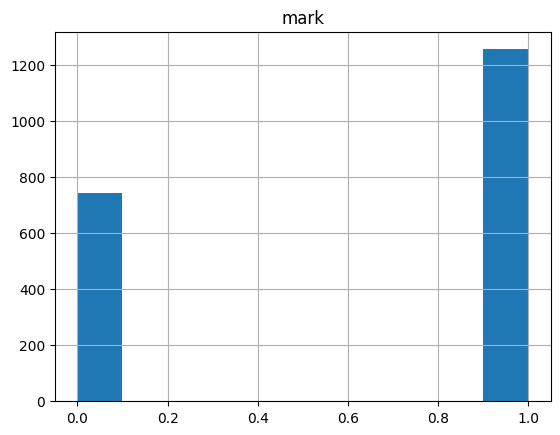

In [86]:
data.hist();

## Проведём обучение модели

In [131]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['mark'], test_size=0.25, random_state=101)

In [132]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

In [133]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [134]:
predictions = pipeline.predict(X_test)

In [137]:
accuracy = accuracy_score(y_test, predictions)
print(f'Точность модели равна {accuracy}')

Точность модели равна 0.684


In [138]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.34      0.47       207
           1       0.67      0.93      0.77       293

    accuracy                           0.68       500
   macro avg       0.72      0.63      0.62       500
weighted avg       0.71      0.68      0.65       500



## Обучим модель на первоначальном датасете

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['mark'], test_size=0.25, random_state=101)


In [123]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), 
                     ('clf', LogisticRegression(max_iter=1000))])

In [124]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [125]:
predictions = pipeline.predict(X_test)

In [128]:
accuracy = accuracy_score(y_test, predictions)
print(f'Точность модели равна {accuracy}')

Точность модели равна 0.706


In [130]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.37      0.49       195
           1       0.70      0.92      0.79       305

    accuracy                           0.71       500
   macro avg       0.72      0.65      0.64       500
weighted avg       0.72      0.71      0.68       500



Эта модель немного улучшена. Разметка данных имеет большое значение для успешной работы модели машинного обучения. Правильная и информативная разметка данных играет важную роль в создании эффективной модели. Таким образом, использование заданных мной правил и библиотеки textblob для разметки данных повлияло на качество модели. Разметка в Label Studio может быть более точной, но требует больше времени для выполнения.